In [1]:
import os

import sys  # <- This is necessary!

# os.chdir('C:\\Users\\Administrator\\Downloads\\ML Lab')
#sys.path.append(r'D:\anaconda\envs')
sys.path.append(r'D:\anaconda\envs')

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [3]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [4]:
def create_lstm():
    input_data = Input(shape=(time_steps, num_features))
    lstm_layer1 = LSTM(8, return_sequences=True)(input_data)
    lstm_layer2 = LSTM(20)(lstm_layer1)
    x = Flatten()(lstm_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [5]:
model1 = create_lstm()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 8)             960       
                                                                 
 lstm_1 (LSTM)               (None, 20)                2320      
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


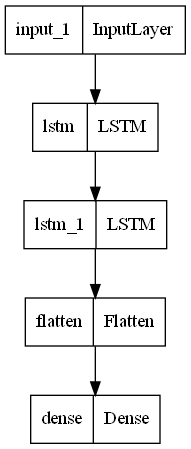

In [6]:
tensorflow.keras.utils.plot_model(model1 )

In [7]:
checkpoints = r'D:\anaconda\envs\lab10\checkpoint\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'D:\anaconda\envs\lab10\checkpoint'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [8]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [9]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_lstm()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [11]:
import os
path_dataset ='D:\\anaconda\\envs\\lab10\\AEP_hourly\\processed'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

D:\anaconda\envs\MLLAB\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [12]:
time_steps=24
num_features=21

In [13]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.3319370746612549 sec


In [14]:
epochs = 40
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/40
2651/2653 [============================>.] - ETA: 0s - loss: 0.0448 - mae: 0.0448 - mape: 1503.7800
Epoch 1: val_loss improved from inf to 0.02639, saving model to D:\anaconda\envs\lab10\checkpoint\E1-cp-0001-loss0.03.h5
2653/2653 [==============================] - 26s 9ms/step - loss: 0.0448 - mae: 0.0448 - mape: 1502.8989 - val_loss: 0.0264 - val_mae: 0.0264 - val_mape: 13.5246
Epoch 2/40
2651/2653 [============================>.] - ETA: 0s - loss: 0.0184 - mae: 0.0184 - mape: 503.4261
Epoch 2: val_loss improved from 0.02639 to 0.01593, saving model to D:\anaconda\envs\lab10\checkpoint\E1-cp-0002-loss0.02.h5
2653/2653 [==============================] - 24s 9ms/step - loss: 0.0184 - mae: 0.0184 - mape: 503.1326 - val_loss: 0.0159 - val_mae: 0.0159 - val_mape: 6.6718
Epoch 3/40
2653/2653 [==============================] - ETA: 0s - loss: 0.0130 - mae: 0.0130 - mape: 197.4489
Epoch 3: val_loss improved from 0.01593 to 0.01114, saving model to D:\anaconda\envs\lab10\checkpoint

In [15]:

model = load_model(r'D:\anaconda\envs\lab10\checkpoint\E1-cp-0040-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 102.83
Median Absolute Error (MedAE): 82.26
Mean Squared Error (MSE): 18522.73
Root Mean Squared Error (RMSE): 136.1
Mean Absolute Percentage Error (MAPE): 0.71 %
Median Absolute Percentage Error (MDAPE): 0.56 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [16]:
checkpoints = r'D:\anaconda\envs\lab10\checkpoint\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'D:\anaconda\envs\lab10\checkpoint\E1-cp-0040-loss0.01.h5'
start_epoch= 34

In [17]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\anaconda\envs\lab10\checkpoint\E1-cp-0040-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [18]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2647/2653 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 44.7768
Epoch 1: val_loss improved from inf to 0.00588, saving model to D:\anaconda\envs\lab10\checkpoint\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 25s 9ms/step - loss: 0.0058 - mae: 0.0058 - mape: 44.6866 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4539
Epoch 2/10
2649/2653 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 11.3470
Epoch 2: val_loss did not improve from 0.00588
2653/2653 [==============================] - 28s 10ms/step - loss: 0.0058 - mae: 0.0058 - mape: 11.3341 - val_loss: 0.0060 - val_mae: 0.0060 - val_mape: 2.5547
Epoch 3/10
2651/2653 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 10.5047
Epoch 3: val_loss did not improve from 0.00588
2653/2653 [==============================] - 28s 11ms/step - loss: 0.0058 - mae: 0.0058 - mape: 10.4996 - val_loss: 0.0059 - val_mae: 0.005

In [19]:

model = load_model(r'D:\anaconda\envs\lab10\checkpoint\E2-cp-0005-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 98.59
Median Absolute Error (MedAE): 75.95
Mean Squared Error (MSE): 17563.58
Root Mean Squared Error (RMSE): 132.53
Mean Absolute Percentage Error (MAPE): 0.67 %
Median Absolute Percentage Error (MDAPE): 0.53 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
